# Chapter 3 Exercises

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import preliz as pz
import pymc as pm


np.random.seed(123)
az.style.use('arviz-white')

## Exercise 1
***

Using your own words explain the following concepts in two or three sentences:

* Complete pooling
* No pooling
* Partial pooling

Bonus. Try asking this to chat-gpt or perplexity. Ask for answers in different styles (like casual, PhD student, etc). Compare those answers to yours and spot differences and similarities.  

## Exercise 2
***

Repeat the exercise we did with `model_h`. This time, without a hierarchical structure, use a flat prior such as Beta(𝛼 = 1, 𝛽 = 1). Compare the results of both models.


We will first load the data and rerun the `model_h`

In [2]:
N_samples = [30, 30, 30]
G_samples = [18, 3, 3] # Try different values
group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data = []
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]-G_samples[i]]))

In [3]:
with pm.Model() as model_h:
    μ = pm.Beta('μ', 1., 1.)
    ν = pm.HalfNormal('ν', 10)
    θ = pm.Beta('θ', mu=μ, nu=ν, shape=len(N_samples))
    y = pm.Bernoulli('y', p=θ[group_idx], observed=data)

    idata_h = pm.sample(random_seed=4591)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, ν, θ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [4]:
with pm.Model() as model_nh:
    θ = pm.Beta('θ', 1, 1, shape=len(N_samples))
    y = pm.Bernoulli('y', p=θ[group_idx], observed=data)

    idata_nh = pm.sample(random_seed=4591)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


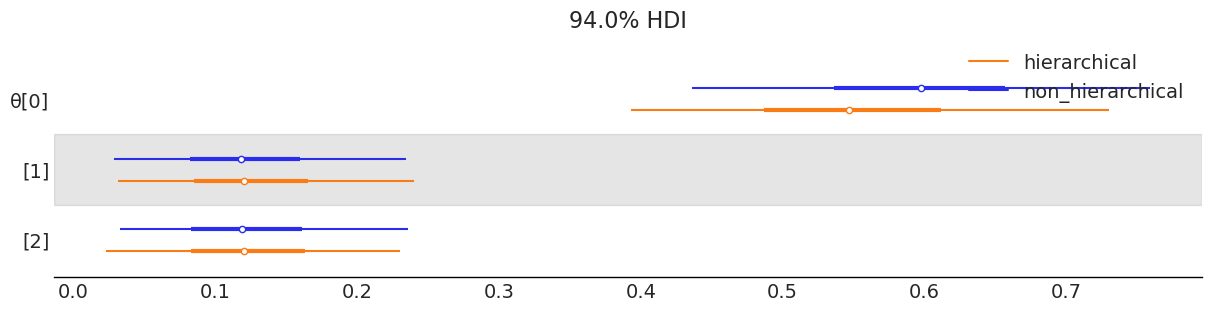

In [5]:
axes = az.plot_forest([idata_nh, idata_h], model_names=['non_hierarchical', 'hierarchical'],
                      var_names='θ', combined=True, r_hat=False, ess=False, figsize=(12, 3),
                      colors='cycle')
y_lims = axes[0].get_ylim()

We can see that the estimates for the second and third groups (`G_samples` = 3) are very similar for both models. But the estimate for the first group (`G_samples` = 18) in the hierarchical model has been "pulled down" compared with the non-hierarchical model.

## Exercise 3
***

Create a hierarchical version of the tips example from Chapter 2, by partially pooling across the days of the week. Compare the results to those obtained without the hierarchical structure.


First we are going to load the data and refit the model from chapter 2.

In [6]:
tips = pd.read_csv("../code/data/tips.csv")
tips.tail()

,total_bill,tip,sex,smoker,day,time,size
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


In [7]:
categories = np.array(["Thur", "Fri", "Sat", "Sun"])

tip = tips["tip"].values
idx = pd.Categorical(tips["day"], categories=categories).codes

In [8]:
coords = {"days": categories, "days_flat":categories[idx]}

with pm.Model(coords=coords) as comparing_groups_nh:
    μ = pm.HalfNormal("μ", sigma=5, dims="days")
    σ = pm.HalfNormal("σ", sigma=1, dims="days")

    y = pm.Gamma("y", mu=μ[idx], sigma=σ[idx], observed=tip, dims="days_flat")

    idata_cg_nh = pm.sample(2000, random_seed=4591)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.


Now we are going to build two hierarhical models:

* For the first one `comparing_groups_h_00`, we just set a hyperprior over $\mu$.
* For the second one `comparing_groups_h_01`, we replace the $\mu \sim \text{HalfNormal}$ for a $\mu \sim \text{Gamma}$ and then set the hyperpriors for both the mean and standard deviation of the Gamma.

In [9]:
coords = {"days": categories, "days_flat":categories[idx]}

with pm.Model(coords=coords) as comparing_groups_h_00:
    μ_g = pm.Gamma("μ_g", mu=5, sigma=2)
    μ = pm.HalfNormal("μ", sigma=μ_g, dims="days")
    σ = pm.HalfNormal("σ", sigma=1, dims="days")

    y = pm.Gamma("y", mu=μ[idx], sigma=σ[idx], observed=tip, dims="days_flat")

    idata_cg_h_00 = pm.sample(random_seed=4591)


with pm.Model(coords=coords) as comparing_groups_h_01:
    μ_g = pm.Gamma("μ_g", mu=5, sigma=2)
    σ_g = pm.Gamma("σ_g", mu=2, sigma=1.5)
    μ = pm.Gamma("μ", mu=μ_g, sigma=σ_g, dims="days")
    σ = pm.HalfNormal("σ", sigma=1, dims="days")

    y = pm.Gamma("y", mu=μ[idx], sigma=σ[idx], observed=tip, dims="days_flat")

    idata_cg_h_01 = pm.sample(random_seed=4591)


# You may also want to try this non_centered version (this is discusssed in Chapter 4)
#with pm.Model(coords=coords) as comparing_groups_h_01:
#    μ_g = pm.Gamma("μ_g", mu=5, sigma=2)
#    σ_g = pm.HalfNormal("σ_g", sigma=2)
#    μ_g_offset = pm.Normal("μ_g_offset", sigma=2, dims="days")
#    
#    μ = pm.Deterministic("μ", μ_g + μ_g_offset * σ_g, dims="days")
#    σ = pm.HalfNormal("σ", sigma=1, dims="days")
#
#    y = pm.Gamma("y", mu=μ[idx], sigma=σ[idx], observed=tip, dims="days_flat")
#
#    idata_cg_h_01 = pm.sample(random_seed=4591, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_g, μ, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_g, σ_g, μ, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 204 divergences after tuning. Increase `target_accept` or reparameterize.


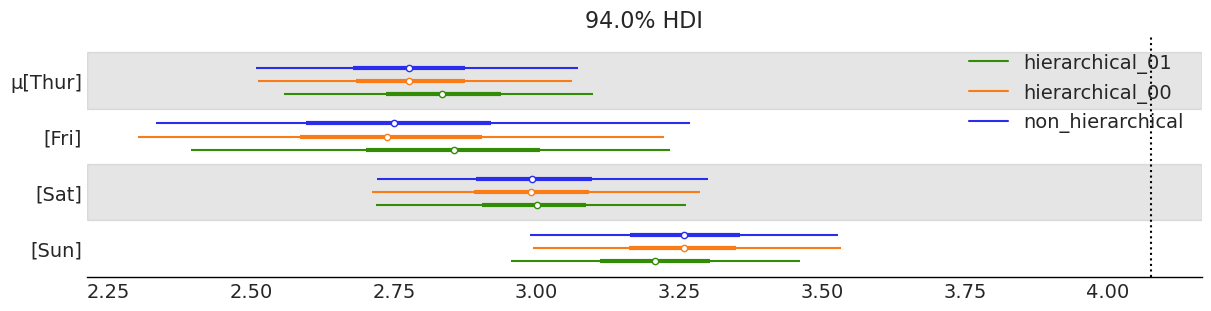

In [10]:
axes = az.plot_forest([idata_cg_nh, idata_cg_h_00, idata_cg_h_01],
                      model_names=['non_hierarchical', 'hierarchical_00', 'hierarchical_01'],
                      var_names=['μ'], combined=True, r_hat=False, ess=False, figsize=(12, 3),
                      colors='cycle')
y_lims = axes[0].get_ylim()
axes[0].vlines(idata_cg_h_00.posterior['μ_g'].mean(), *y_lims, color="k", ls=":");

We can see little if any difference between the hierarchical and non-hierarchical versions of these models when we use a HalfNormal distribution for the mean μ (`hierarchical_01` and `non_hierarchical`, respectively). The difference is larger when we use a Gamma (`hierarchical_01`) instead. The Gamma with its two parameters is a more flexible distribution. 

## Exercise 4
***

For each subpanel in Figure 3.7, add a reference line representing the empirical mean
value at each level, that is, the global mean, the forward mean, and Messi’s mean.
Compare the empirical values to the posterior mean values. What do you observe?

In [11]:
football = pd.read_csv("../code/data/football_players.csv", dtype={'position':'category'})
football["gps"] = football["goals"] / football["shots"]

In [12]:
pos_idx = football.position.cat.codes.values
pos_codes = football.position.cat.categories
n_pos = pos_codes.size
n_players = football.index.size

In [13]:
coords = {"pos": pos_codes}
with pm.Model(coords=coords) as model_football:
    # Hyper parameters
    μ = pm.Beta('μ', 1.7, 5.8) 
    ν = pm.Gamma('ν', mu=125, sigma=50)

    
    # Parameters for positions
    μ_p = pm.Beta('μ_p',
                       mu=μ,
                       nu=ν,
                       dims = "pos")
    
    ν_p = pm.Gamma('ν_p', mu=125, sigma=50, dims="pos")
 
    # Parameter for players
    θ = pm.Beta('θ', 
                    mu=μ_p[pos_idx],
                    nu=ν_p[pos_idx])
    
    _ = pm.Binomial('gs', n=football.shots.values, p=θ, observed=football.goals.values)

    idata_football = pm.sample(draws=3000, target_accept=0.95, random_seed=4591)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, ν, μ_p, ν_p, θ]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 203 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Text(0.5, 1.0, 'Messi mean')

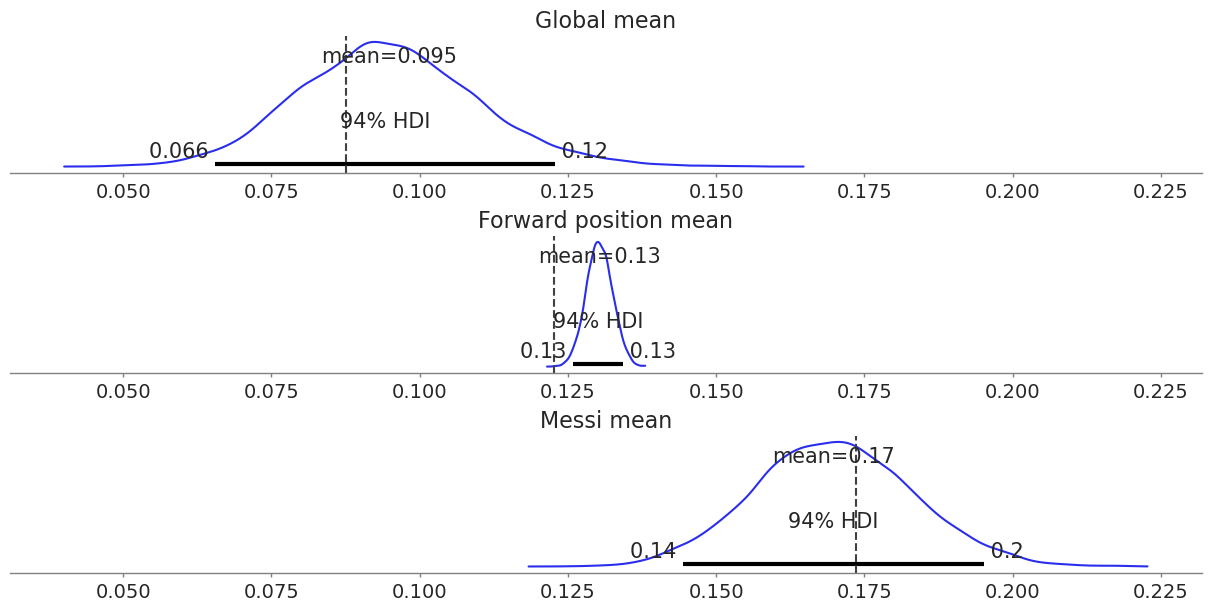

In [14]:
_, ax = plt.subplots(3, 1, figsize=(12, 6), sharex=True)
az.plot_posterior(idata_football, var_names='μ', ax=ax[0])
ax[0].axvline(football["gps"].mean(), color="0.25", ls="--")
ax[0].set_title(r"Global mean")
az.plot_posterior(idata_football.posterior.sel(pos="FW"), var_names='μ_p', ax=ax[1])
ax[1].axvline(football["gps"][football["position"] == "FW"].mean(), color="0.25", ls="--")
ax[1].set_title(r"Forward position mean")
az.plot_posterior(idata_football.posterior.sel(θ_dim_0=1457), var_names='θ', ax=ax[2])
ax[2].axvline(football["gps"][football["name"] == "Lionel Messi"].item(), color="0.25", ls="--")
ax[2].set_title(r"Messi mean")

## Exercise 5
***
Amino acids are usually grouped into categories such as polar, non-polar, charged,
and special. Build a hierarchical model similar to cs_h but including a group effect
for the amino acid category. Compare the results to those obtained in this chapter.

In [15]:
cs_data = pd.read_csv('../code/data/chemical_shifts_theo_exp.csv')
diff = cs_data.theo - cs_data.exp
cat_encode = pd.Categorical(cs_data['cat'])
idx = cat_encode.codes
coords = {"cat": cat_encode.categories}

In [16]:
with pm.Model(coords=coords) as cs_h_cat:
    # hyper_priors
    μ_mu = pm.Normal('μ_mu', mu=0, sigma=10)
    μ_sd = pm.HalfNormal('μ_sd', 10)

    # priors
    μ = pm.Normal('μ', mu=μ_mu, sigma=μ_sd, dims="cat") 
    σ = pm.HalfNormal('σ', sigma=10, dims="cat") 

    y = pm.Normal('y', mu=μ[idx], sigma=σ[idx], observed=diff) 

    idata_cs_h_cat = pm.sample(tune=2000, random_seed=4591, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_mu, μ_sd, μ, σ]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 25 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


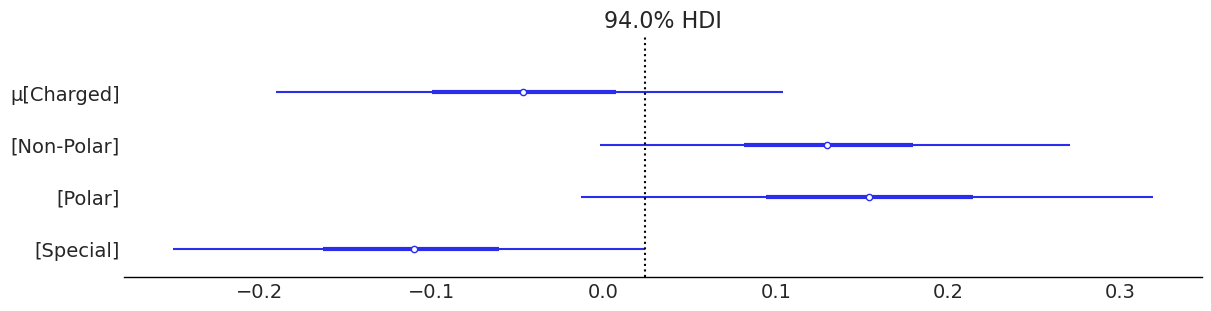

In [17]:
axes = az.plot_forest(idata_cs_h_cat,
                      var_names='μ', combined=True, r_hat=False, ess=False, figsize=(12, 3))
y_lims = axes[0].get_ylim()
axes[0].vlines(idata_cs_h_cat.posterior['μ_mu'].mean(), *y_lims, color="k", ls=":");